In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#### Import datasets

XOR gate.

In [2]:
fluos = pd.read_csv('datasets/bulk_fluo_xor.csv', index_col='time')
ods = pd.read_csv('datasets/od_xor.csv', index_col='time')

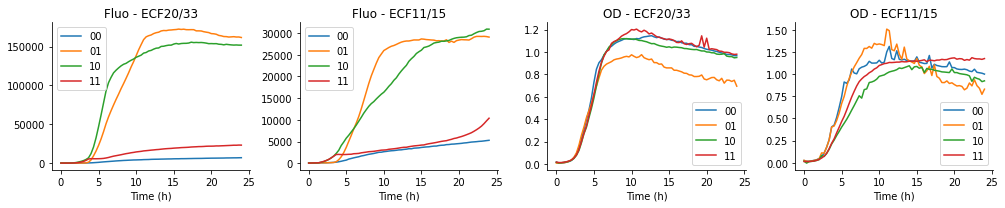

In [3]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(14, 3))
axr = axs.ravel()
for i in range(4):
    axr[0].plot(fluos.index/60, fluos.iloc[:,i], label='{:02b}'.format(int(i)))
axr[0].set_xlabel('Time (h)')
axr[0].set_title('Fluo - ECF20/33')
axr[0].legend()
for i in range(4,8):
    axr[1].plot(fluos.index/60, fluos.iloc[:,i], label='{:02b}'.format(int(i-4)))
axr[1].set_xlabel('Time (h)')
axr[1].set_title('Fluo - ECF11/15')
axr[1].legend()
for i in range(4):
    axr[2].plot(ods.index/60, ods.iloc[:,i], label='{:02b}'.format(int(i)))
axr[2].set_xlabel('Time (h)')
axr[2].set_title('OD - ECF20/33')
axr[2].legend()
for i in range(4,8):
    axr[3].plot(ods.index/60, ods.iloc[:,i], label='{:02b}'.format(int(i-4)))
axr[3].set_xlabel('Time (h)')
axr[3].set_title('OD - ECF11/15')
axr[3].legend()
plt.tight_layout()
sns.despine()

#### ODE Models

In [5]:
def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

def od_wrapper(t, k1, k2, c0):
    
    def od_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    od_rates = (k1, k2)
    od_sol = odeint(od_model, c0, t, od_rates)
    return od_sol[:,0]

def od_inference(od):
    od_bounds = [(0, 0, 0), (1, 2, 0.1)]
    od_params = []
    od_t = od.index
    for idx in range(od.shape[1]):
        od_data = od.iloc[:,idx]
        opt, _ = curve_fit(od_wrapper, od_t, od_data, bounds=od_bounds)
        od_params.append(opt)
    return od_params

In [6]:
od_params_sel = od_inference(ods)
od_params_sel

[array([0.0217037 , 1.07254192, 0.00333273]),
 array([0.02321768, 0.85225317, 0.00285955]),
 array([0.02175661, 1.04536505, 0.00239121]),
 array([0.02001975, 1.09769651, 0.0038524 ]),
 array([0.01947871, 1.11387098, 0.00659902]),
 array([0.02087982, 1.09156765, 0.00417227]),
 array([0.01129633, 1.02578282, 0.01938749]),
 array([0.01247218, 1.15436415, 0.01694831])]

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(od_params_sel):
        r, K, c0 = od_params_sel[i]
        ax.scatter(od_01.index/60, od_01.iloc[:, i], c='slategrey', s=5)
        ax.plot(od_01.index/60, od_wrapper(od_01.index, r, K, c0), c='deeppink')
        ax.set_title(od_11.columns[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
fluo_01 = fluos[['ECF20/33_01', 'ECF11/15_01']]
od_01 = ods[['ECF20/33_01', 'ECF11/15_01']]

In [7]:
#model
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

#model with auto-fluorescence term
def gate_wrapper(t, ba1, be2, ba2, be1, bg, syn_a1, syn_e2, syn_a2, syn_e1, syn_g1, syn_g2, da1, de2, da2, de1, deg_GFP, spl_e2, spl_e1, a, K1, n1, K2, n2, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        AS1, ECF2, AS2, ECF1, GFP, Auto, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAS1 = ba1 + syn_a1 * ind1 - (da1 + gamma) * AS1
        dECF2 = be2 + syn_e2 * ind1 - (de2 + gamma + spl_e2 * AS2) * ECF2
        dAS2 = ba2 + syn_a2 * ind2 - (da2 + gamma) * AS2
        dECF1 = be1 + syn_e1 * ind2 - (de1 + gamma + spl_e1 * AS1) * ECF2
        dGFP = bg + syn_g1 * hill_equation(ECF1, K1, n1) + syn_g2 * hill_equation(ECF2, K2, n2) - (deg_GFP + gamma) * GFP
        
        dAuto = a - gamma * Auto

        return [dAS1, dECF2, dAS2, dECF1, dGFP, dAuto, dOD]
    
    #print(y0)
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#### Simulate All States

In [33]:
#objective function
def computeSSE_global(init_params, f_t, f_data, bounds, od_params):
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t_, u, v, w, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t_, u, v, w, ind1, ind2, extra, y0)
        return pd.Series(fit[4])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t_, u, v, w):
        result = [model_fit_inner(f_t[:int(len(f_t)/4)], a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t_, u, v, w, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(6), od_params[n][2])) \
                                   for n in range(4)]
        return pd.concat(result)
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)


#generate random numbers from a uniform distribution for initial guesses
def randomSearch_global(iterations, num_params, f_t, f_data, bounds, od_params):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE_global(guess, f_t, f_data, bounds, od_params)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [41]:
def simulate_all_states(fluo, od_params, g):
    
    num_states = 4
    num_vars = 6
    parameters = list(par.keys())
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(num_vars), od_params[i][2])) for i in range(num_states)])
    
    #gate_bounds = [lower_bounds, upper_bounds]
    #init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    #f_params = [g[par] for par in parameters]
    
    
    init_guesses = [g[i] for i in parameters]
    
    lower_bounds = [i/100 for i in init_guesses]
    upper_bounds = [i*100 for i in init_guesses]
    gate_bounds = [lower_bounds, upper_bounds]
    '''
    init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    lower_bounds = [i/100 for i in init_guesses]
    upper_bounds = [i*100 for i in init_guesses]
    gate_bounds = [lower_bounds, upper_bounds]
    '''
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t_, u, v, w, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t_, u, v, w, ind1, ind2, extra, y0)
        return pd.Series(fit[4])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t_, u, v, w):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t_, u, v, w, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(num_vars), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [42]:
par = {
    'ba1': 1 * 10**-5,
    'be2': 1 * 10**-5,
    'ba2': 1 * 10**-5,
    'be1': 1 * 10**-5,
    'bg': 1 * 10**-5,
    'syn_a1': 4 * 10**0,
    'syn_e2': 4 * 10**0,
    'syn_a2': 4 * 10**0,
    'syn_e1': 4 * 10**0,
    'syn_g1': 25 * 10**1,
    'syn_g2': 25 * 10**1,
    'da1': 10 * 10**-3,
    'de2': 10 * 10**-3,
    'da2': 10 * 10**-3,
    'de1': 10 * 10**-3,
    'deg_GFP': 85 * 10**-4,
    'spl_e2': 5 * 10**3,
    'spl_e1': 5 * 10**3,
    'a': 1 * 10**-5,
    'K1': 12 * 10**2,
    'n1': 4,
    'K2': 12 * 10**2,
    'n2': 4
}

f_df_res, f_sim_res, f_t_res, f_data_res = simulate_all_states(fluos.iloc[:,:4], od_params_sel[:4], par)

ValueError: Residuals are not finite in the initial point.

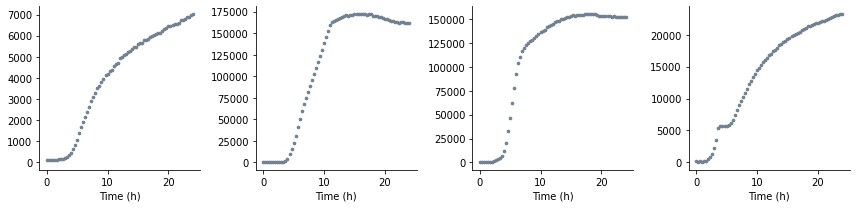

In [40]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluos.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    #ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### Fitting Only 11 State

In [ ]:
par1 = {
    'ba1': 1 * 10**-5,
    'be2': 1 * 10**-5,
    'ba2': 1 * 10**-5,
    'be1': 1 * 10**-5,
    'bg': 1 * 10**-5,
    'syn_a1': 4 * 10**0,
    'syn_e2': 4 * 10**0,
    'syn_a2': 4 * 10**0,
    'syn_e1': 4 * 10**0,
    'syn_g1': 25 * 10**1,
    'syn_g2': 25 * 10**1,
    'da1': 10 * 10**-3,
    'de2': 10 * 10**-3,
    'da2': 10 * 10**-3,
    'de1': 10 * 10**-3,
    'deg_GFP': 85 * 10**-4,
    'spl_e2': 5 * 10**3,
    'spl_e1': 5 * 10**3,
    'a': 1 * 10**-5,
    'K1': 12 * 10**2,
    'n1': 4,
    'K2': 12 * 10**2,
    'n2': 4
}
par2 = {
    'ba1': 1 * 10**-5,
    'be2': 1 * 10**-5,
    'ba2': 1 * 10**-5,
    'be1': 1 * 10**-5,
    'bg': 1 * 10**-5,
    'syn_a1': 4 * 10**0,
    'syn_e2': 4 * 10**0,
    'syn_a2': 4 * 10**0,
    'syn_e1': 4 * 10**0,
    'syn_g1': 15 * 10**2,
    'syn_g2': 15 * 10**2,
    'da1': 10 * 10**-3,
    'de2': 10 * 10**-3,
    'da2': 10 * 10**-3,
    'de1': 10 * 10**-3,
    'deg_GFP': 87 * 10**-4,
    'spl_e2': 5 * 10**3,
    'spl_e1': 5 * 10**3,
    'a': 1 * 10**-5,
    'K1': 12 * 10**2,
    'n1': 4,
    'K2': 12 * 10**2,
    'n2': 4
}

In [11]:
par = {
    'ba1': 0.28604086105706816,
    'be2': 0.3563295154307664,
    'ba2': 0.9819167621189833,
    'be1': 0.3553967250899448,
    'bg': 313.64493497364174,
    'syn_a1': 1.0,
    'syn_e2': 1.0,
    'syn_a2': 0.9819167621189837,
    'syn_e1': 0.3553967250899451,
    'syn_g1': 361.3168604286475,
    'syn_g2': 473.30212291724666,
    'da1': 2.0694767271430936,
    'de2': 0.2364091136254879,
    'da2': 1.664732888881067,
    'de1': 0.28099493419140764,
    'deg_GFP': 0.04999731970747018,
    'spl_e2': 1.0413757478711971,
    'spl_e1': 0.8008077016887967,
    'a':  0.03669528934384454,
    'K1': 0.13128848207444052,
    'n1': 0.33998388827454257,
    'K2': 0.025202951875776758,
    'n2': 3.2592503134967465
}

def fit_single_state(fluo, od_params, ind1, ind2):
    
    parameters = list(par.keys())
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(6), od_params[2]))
    
    init_guesses = [par[i] for i in parameters]
    lower_bounds = [i/100 for i in init_guesses]
    upper_bounds = [i*100 for i in init_guesses]
    #lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
    #upper_bounds = [1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e1, 1e1, 1e1, 1e1, 1e3, 1e3, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e4, 1e4, 1e-2, 1e4, 4, 1e4, 4]
    gate_bounds = [lower_bounds, upper_bounds]
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t_, u, v, w):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t_, u, v, w, ind1, ind2, extra, y0)
        return pd.Series(fit[4])
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data
    #f_sim = model_fit(f_t, *list(par.values()))
    #return None, f_sim, f_t, f_data

In [ ]:
col = 1
f_df, f_sim, f_t, f_data = fit_single_state(fluo_01.iloc[:,col], od_params_sel[col], 0, 1)
plt.scatter(f_t/60, f_data, c='slategrey', s=7)
plt.plot(f_t/60, f_sim, c='deeppink')
plt.title(fluo_01.columns.tolist()[col])
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
f_df[['Parameters', 'Value']].set_index('Parameters').to_dict()

In [ ]:
par2 = {
    'ba1': 1 * 10**-5,
    'be2': 1 * 10**-5,
    'ba2': 1 * 10**-5,
    'be1': 1 * 10**-5,
    'bg': 1 * 10**-5,
    'syn_a1': 4 * 10**0,
    'syn_e2': 4 * 10**0,
    'syn_a2': 4 * 10**0,
    'syn_e1': 4 * 10**0,
    'syn_g1': 15 * 10**2,
    'syn_g2': 15 * 10**2,
    'da1': 10 * 10**-3,
    'de2': 10 * 10**-3,
    'da2': 10 * 10**-3,
    'de1': 10 * 10**-3,
    'deg_GFP': 87 * 10**-4,
    'spl_e2': 5 * 10**3,
    'spl_e1': 5 * 10**3,
    'a': 1 * 10**-5,
    'K1': 12 * 10**2,
    'n1': 4,
    'K2': 12 * 10**2,
    'n2': 4
}

col = 0
f_df, f_sim, f_t, f_data = fit_single_state(fluo_01.iloc[:,col], od_params_sel[col], 0, 1)
plt.scatter(f_t/60, f_data, c='slategrey', s=7)
plt.plot(f_t/60, f_sim, c='deeppink')
plt.title(fluo_01.columns.tolist()[col])
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### Fitting Altogether

In [ ]:
f_dfs = []
f_sims = []
f_ts = []
f_datas = []
for sel, gate in tqdm(enumerate(gates)):
    
    gate = gates[sel]
    #print(sel, gate)
    fluo_sel = pd.concat([fluos[i].iloc[:,sel] for i in range(4)], axis=1)
    od_sel = pd.concat([ods[i].iloc[:,sel] for i in range(4)], axis=1)
    
    od_params_sel = od_inference(od_sel)
    #od_params.append(od_params_sel)
    
    f_df, f_sim, f_t, f_data = fit_single_state(fluo_sel.iloc[:,n], od_params_sel[n], int(n/2), n%2)
    f_dfs.append(f_df)
    f_sims.append(f_sim)
    f_ts.append(f_t)
    f_datas.append(f_data)
    
#len(od_params)

Fitting with sampling initial guesses.

In [ ]:
f, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(14, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_ts[i]/60, f_datas[i], c='slategrey', s=7)
        ax.plot(f_ts[i]/60, f_sims[i], c='deeppink')
        ax.set_title(gates[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

Fitting without sampling initial guesses.

In [ ]:
f, axs = plt.subplots(2, 6, sharex=True, sharey=False, figsize=(14, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_ts[i]/60, f_datas[i], c='slategrey', s=7)
        ax.plot(f_ts[i]/60, f_sims[i], c='deeppink')
        ax.set_title(gates[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

#### Parameters

In [ ]:
def plot_parameters(f_df, show_err=True):
    
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])
    
    f, axs = plt.subplots(int(n_paras/3), 3, sharex=True, figsize=(16, (n_paras+1)/2))
    for i, ax in enumerate(axs.ravel()):
        if i < n_paras:
            if show_err:
                ax.errorbar(gates, values[:,i], errors[:,i], fmt='o', label='experiment')
            else:
                ax.scatter(gates, values[:,i], label='experiment')
            ax.set_ylabel(parameters[i])
        else:
            ax.set_visible(False)
        #ax.set_xticks(rotation=90) 
        ax.set_xticklabels(gates, rotation=90)
    sns.despine()
    plt.tight_layout()
    
plot_parameters(f_dfs)

#### Manual Fitting

In [ ]:
def simulate_single_state(fluo, od_params, title, ind1, ind2):
    
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'a', 'K', 'n']
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params = [par[i] for i in parameters]
    f_sim = model_fit(f_t, *f_params)
    return f_t, f_data, f_sim

In [ ]:
par = {
    'bn': 1 * 10**-1,
    'bc': 1 * 10**-1,
    'bg': 1 * 10**-2,
    'syn_ECFn': 4 * 10**0,
    'syn_ECFc': 4 * 10**0,
    'syn_ECF': 50 * 10**-10,
    'deg': 7 * 10**-3,
    'syn_GFP': 1 * 10**4,
    'deg_GFP': 1 * 10**-2,
    'K': 1 * 10**-1,
    'n': 2 * 10**0
}

In [ ]:
f, axs = plt.subplots(3, 4, figsize=(16, 2*3), sharey=False)
for m in range(1, 2):
    for i in range(0, 5):

        par = {
            'bn': 1 * 10**-10,
            'bc': 1 * 10**-10,
            'bg': 8 * 10**1,
            'syn_ECFn': 4 * 10**1,
            'syn_ECFc': 4 * 10**1,
            'syn_ECF': 50 * 10**-10,
            'deg': 7 * 10**-3,
            'syn_GFP': 3 * 10**3,
            'deg_GFP': 2 * 10**-2,
            'K': 5 * 10**-1,
            'n': 2 * 10**0
        }
        #print(par['n'])
        for n in range(4):
            f_t_sin, f_data_sin, f_sim_sin = simulate_single_state(fluo_sel.iloc[:,n], od_params_sel[n], gates[sel], int(n/2), n%2)
            axs[m-1, n].plot(f_t_sin/60, f_sim_sin, label=i)
            axs[m-1, n].legend()
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

In [ ]:
f_t = np.concatenate([fluo_sel.index] * 4)
f_data = pd.concat([fluo_sel.iloc[:,i] for i in range(4)])
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t[idx*i:idx*(i+1)]/60, f_data[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### More elegant fitting

In [ ]:
#objective function
def computeSSE(init_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        #guess.append(np.random.uniform(low=1,high=4))
        error = computeSSE(guess, f_t, f_data, bounds, od_params, ind1, ind2)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
def fit_single_state(fluo, od_params, ind1, ind2):
    
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    upper_bounds = [1e1, 1e1, 1e1, 1e2, 1e2, 1e-4, 1e-1, 1e5, 1e0, 1e2, 4]
    gate_bounds = [lower_bounds, upper_bounds]
    
    init_guesses = randomSearch(10, len(parameters), f_t, f_data, gate_bounds, od_params, ind1, ind2)
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
f_df_sin_all = []
for n in range(4):
    f_df_sin, f_sim_sin, f_t_sin, f_data_sin = fit_single_state(fluo_sel.iloc[:,n], od_params_sel[n], int(n/2), n%2)
    f_df_sin_all.append(f_df_sin)

In [ ]:
guesses = []
lowers = []
uppers = []
for param in tqdm(f_df_sin['Parameters']):
    vals = [i.loc[i['Parameters']==param, 'Value'].values for i in f_df_sin_all]
    lows = [(i.loc[i['Parameters']==param, 'Value'].values - i.loc[i['Parameters']==param, 'Err'].values) for i in f_df_sin_all]
    highs = [(i.loc[i['Parameters']==param, 'Value'].values + i.loc[i['Parameters']==param, 'Err'].values) for i in f_df_sin_all]
    #print('v', vals) 
    #print('l', lows)
    #print('h', highs)
    guesses.append(np.mean(vals))
    lowers.append(np.mean(lows))
    uppers.append(np.mean(highs))
lowers = [i if i >= 0 else 0 for i in lowers]

In [ ]:
guesses, lowers, uppers

In [ ]:
#objective function
def computeSSE_global(init_params, f_t, f_data, bounds, od_params):
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(f_t[:int(len(f_t)/4)], a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(4)]
        return pd.concat(result)
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)


#generate random numbers from a uniform distribution for initial guesses
def randomSearch_global(iterations, num_params, f_t, f_data, bounds, od_params):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE_global(guess, f_t, f_data, bounds, od_params)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
def fit_all_states(fluo, od_params, _init_guesses, lower_bounds, upper_bounds):
    
    num_states = 4
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(4), od_params[i][2])) for i in range(num_states)])
    
    gate_bounds = [lower_bounds, upper_bounds]
    
    init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
f_df_res, f_sim_res, f_t_res, f_data_res = fit_all_states(fluo_sel, od_params_sel, guesses, lowers, uppers)

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()

#### Tuning the Parameter Grid

In [ ]:
def simulate_all_states(fluo, od_params, g):
    
    num_states = 4
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(4), od_params[i][2])) for i in range(num_states)])
    
    #gate_bounds = [lower_bounds, upper_bounds]
    
    #init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    f_params = [g[par] for par in parameters]
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params})#, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
from sklearn.model_selection import ParameterGrid

params = {
    'bn': [1e0, 1e-1],
    'bc': [1e0, 1e-1],
    'bg': [1e-3, 1e-2],
    'syn_ECFn': [4e1, 4e0],
    'syn_ECFc': [4e1, 4e0],
    'syn_ECF': [50e-11, 50e-10],
    'deg': [7e-4, 7e-3],
    'syn_GFP': [1e5, 1e4],
    'deg_GFP': [1e-3, 1e-2],
    'K': [1e-2, 1e-1],
    'n': [2, 3]
}

tuned_results = []
grid = ParameterGrid(params)
for g in tqdm(grid):
    #print(g)
    f_df_res, f_sim_res, f_t_res, f_data_res = simulate_all_states(fluo_sel, od_params_sel, g)
    tuned_results.append((f_df_res, f_sim_res))

In [ ]:
oridata = f_data_res.reset_index(drop=True) * 4
errs = []
for i in range(len(tuned_results)):
    tardata = tuned_results[i][1].reset_index(drop=True)
    errs.append(np.sum((oridata - tardata)**2))

In [ ]:
errs.index(np.min(errs)), errs[errs.index(np.min(errs))]

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, tuned_results[errs.index(np.min(errs))][1][idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
np.min(errs), np.max(errs)

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()

#### Simulated Data

In [ ]:
od_sim_data = []
for r, K, c0 in od_params_sel:
    #r, K, c0 = od_params_selected[sel]
    od_sim = od_wrapper(od_sel.index, r, K, c0)
    od_noise = (od_sim.max() * 0.01) * np.random.normal(size=idx)
    od_t = od_sel.index
    od_new = pd.Series(od_sim+od_noise, index=od_t)
    od_sim_data.append(od_new)
    plt.plot(od_t/60, od_new, label=gates[sel])
#plt.legend()
plt.title('Simulated OD')
sns.despine()
plt.show()

In [ ]:
od_sim_df = pd.concat([od_sim_data[0], od_sim_data[1]], axis=1)
od_sim_df = pd.concat([od_sim_df, od_sim_data[2]], axis=1)
od_sim_df = pd.concat([od_sim_df, od_sim_data[3]], axis=1)
od_sim_df = od_sim_df.set_axis(['00', '01', '10', '11'], axis=1)

In [ ]:
idx = len(fluo_sel.iloc[:,0])
noise = (f_sim_res.max() * 0.01) * np.random.normal(size=idx)
sim_00 = pd.Series(f_sim_res[0*idx:1*idx]+noise, index=f_t_res[0*idx:1*idx])
sim_01 = pd.Series(f_sim_res[1*idx:2*idx]+noise, index=f_t_res[1*idx:2*idx])
sim_10 = pd.Series(f_sim_res[2*idx:3*idx]+noise, index=f_t_res[2*idx:3*idx])
sim_11 = pd.Series(f_sim_res[3*idx:4*idx]+noise, index=f_t_res[3*idx:4*idx])

plt.plot(f_t_res[0*idx:1*idx], sim_00)
plt.plot(f_t_res[1*idx:2*idx], sim_01)
plt.plot(f_t_res[2*idx:3*idx], sim_10)
plt.plot(f_t_res[3*idx:4*idx], sim_11)
plt.title('Simulated Fluorescence')
sns.despine()
plt.show()

In [ ]:
fluo_sel2 = pd.concat([sim_00, sim_01], axis=1)
fluo_sel2 = pd.concat([fluo_sel2, sim_10], axis=1)
fluo_sel2 = pd.concat([fluo_sel2, sim_11], axis=1)

od_params_sel2 = od_inference(od_sim_df)

f_t_res2, f_df_res2, f_sim_res2, f_data_res2 = fit_multiple(fluo_sel2, od_params_sel2)

In [ ]:
fig, ax = plt.subplots()
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
er1 = ax.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.', transform=trans1, label='experiment')
er2 = ax.errorbar(f_df_res2['Parameters'], f_df_res2['Value'], f_df_res2['Err'], fmt='.', transform=trans2, label='simulated')
plt.legend()
plt.xticks(rotation=90)
plt.show()

#### Modeling All Gates

In [ ]:
gates = fluo11.columns.tolist()
#gates.remove('e38TerThyXS2') #for some reasons it did not work with this gate, so remove it for now
f_t_res_all = []
f_df_res_all = []
f_sim_res_all = []
f_data_res_all = []
od_simulated_df_all = []

for gate in tqdm(gates):
    
    fluo_selected = pd.concat([fluo00[gate], fluo01[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo10[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo11[gate]], axis=1)
    od_selected = pd.concat([od00[gate], od01[gate]], axis=1)
    od_selected = pd.concat([od_selected, od10[gate]], axis=1)
    od_selected = pd.concat([od_selected, od11[gate]], axis=1)
    
    od_params_selected = od_inference(od_selected)
    
    od_simulated_data = []
    for r, K, c0 in od_params_selected:
        #r, K, c0 = od_params_selected[sel]
        od_sim = od_wrapper(od_selected.index, r, K, c0)
        od_noise = (od_sim.max() * 0.01) * np.random.normal(size=len(od_sim))
        od_t = od_selected.index
        od_new_data = pd.Series(od_sim+od_noise, index=od_t)
        od_simulated_data.append(od_new_data)
    
    od_simulated_df = pd.concat([od_simulated_data[0], od_simulated_data[1]], axis=1)
    od_simulated_df = pd.concat([od_simulated_df, od_simulated_data[2]], axis=1)
    od_simulated_df = pd.concat([od_simulated_df, od_simulated_data[3]], axis=1)
    od_simulated_df_all.append(od_simulated_df)
    
    f_t_res, f_df_res, f_sim_res, f_data_res = fit_multiple(fluo_selected, od_params_selected)
    f_t_res_all.append(f_t_res)
    f_df_res_all.append(f_df_res)
    f_sim_res_all.append(f_sim_res)
    f_data_res_all.append(f_data_res)

In [ ]:
f_t_res_all2 = []
f_df_res_all2 = []
f_sim_res_all2 = []
f_data_res_all2 = []

for sel in tqdm(range(len(gates))):
    
    idx = len(fluo_selected.iloc[:,0])
    noise = (f_sim_res_all[sel].max() * 0.01) * np.random.normal(size=idx)
    simulated_00 = pd.Series(f_sim_res_all[sel][0*idx:1*idx]+noise, index=f_t_res_all[sel][0*idx:1*idx])
    simulated_01 = pd.Series(f_sim_res_all[sel][1*idx:2*idx]+noise, index=f_t_res_all[sel][1*idx:2*idx])
    simulated_10 = pd.Series(f_sim_res_all[sel][2*idx:3*idx]+noise, index=f_t_res_all[sel][2*idx:3*idx])
    simulated_11 = pd.Series(f_sim_res_all[sel][3*idx:4*idx]+noise, index=f_t_res_all[sel][3*idx:4*idx])

    fluo_selected2 = pd.concat([simulated_00, simulated_01], axis=1)
    fluo_selected2 = pd.concat([fluo_selected2, simulated_10], axis=1)
    fluo_selected2 = pd.concat([fluo_selected2, simulated_11], axis=1)

    od_params_selected2 = od_inference(od_simulated_df_all[sel])

    f_t_res2, f_df_res2, f_sim_res2, f_data_res2 = fit_multiple(fluo_selected2, od_params_selected2)
    f_t_res_all2.append(f_t_res2)
    f_df_res_all2.append(f_df_res2)
    f_sim_res_all2.append(f_sim_res2)
    f_data_res_all2.append(f_data_res2)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(f_t_res_all):
        ax.scatter(f_t_res_all[i][-len(fluo_selected.iloc[:,0]):]/60, f_data_res_all[i][-len(fluo_selected.iloc[:,0]):], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][-len(fluo_selected.iloc[:,0]):]/60, f_sim_res_all[i][-len(fluo_selected.iloc[:,0]):], c='deeppink')
        ax.set_title(gates[i] + ' - 11')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][:len(fluo_selected.iloc[:,0])]/60, f_data_res_all[i][:len(fluo_selected.iloc[:,0])], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][:len(fluo_selected.iloc[:,0])]/60, f_sim_res_all[i][:len(fluo_selected.iloc[:,0])], c='deeppink')
        ax.set_title(gates[i] + ' - 00')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][idx:2*idx]/60, f_data_res_all[i][idx:2*idx], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][idx:2*idx]/60, f_sim_res_all[i][idx:2*idx], c='deeppink')
        ax.set_title(gates[i] + ' - 01')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][2*idx:3*idx]/60, f_data_res_all[i][2*idx:3*idx], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][2*idx:3*idx]/60, f_sim_res_all[i][2*idx:3*idx], c='deeppink')
        ax.set_title(gates[i] + ' - 10')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
def plot_parameters(f_df, f_df2=None, show_err=True, compare=False):
    
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])
    
    if f_df2 is not None:
        parameters2 = f_df2[0]['Parameters'].values
        #n_paras = len(parameters)
        values2 = np.stack([df2['Value'].values for df2 in f_df2])
        errors2 = np.stack([df2['Err'].values for df2 in f_df2])

    f, axs = plt.subplots(n_paras, 1, sharex=True, figsize=(10, 2*(n_paras+1)))
    for i, ax in enumerate(axs):

        trans1 = Affine2D().translate(-0.2, 0.0) + ax.transData
        trans2 = Affine2D().translate(+0.2, 0.0) + ax.transData

        if show_err:
            ax.errorbar(gates, values[:,i], errors[:,i], fmt='o', label='experiment', transform=trans1)
            if compare:
                ax.errorbar(gates, values2[:,i], errors2[:,i], fmt='o', label='simulated', transform=trans2)
        else:
            ax.scatter(gates, values[:,i], label='experiment', transform=trans1)
            if compare:
                ax.scatter(gates, values2[:,i], label='simulated', transform=trans2)
        ax.set_ylabel(parameters[i])
        if compare:
            ax.legend()
    plt.xticks(rotation=90)
    sns.despine()
    
plot_parameters(f_df_res_all)

In [ ]:
plot_parameters(f_df_res_all, show_err=False)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.errorbar(f_df_res_all[i]['Parameters'], f_df_res_all[i]['Value'], f_df_res_all[i]['Err'], fmt='.')
        #ax.set_xticks(rotation=90)
        ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)
        ax.set_title(gates[i])
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
plot_parameters(f_df_res_all, f_df_res_all2, compare=True, show_err=False)

In [ ]:
plot_parameters(f_df_res_all, f_df_res_all2, compare=True, show_err=True)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.errorbar(f_df_res_all[i]['Parameters'], f_df_res_all[i]['Value'], f_df_res_all[i]['Err'], fmt='.', label='experiment')
        ax.errorbar(f_df_res_all2[i]['Parameters'], f_df_res_all2[i]['Value'], f_df_res_all2[i]['Err'], fmt='.', label='simulated')

        ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)
        ax.set_title(gates[i])
        ax.legend()
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(f_t_res_all2):
        ax.scatter(f_t_res_all2[i][-len(fluo_selected.iloc[:,0]):]/60, f_data_res_all2[i][-len(fluo_selected.iloc[:,0]):], c='slategrey', s=7)
        ax.plot(f_t_res_all2[i][-len(fluo_selected.iloc[:,0]):]/60, f_sim_res_all2[i][-len(fluo_selected.iloc[:,0]):], c='deeppink')
        ax.set_title(gates[i] + ' - 11')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()